In [1]:
from seirsplus.models import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import json
import  pickle
from shapely.geometry import Polygon, Point, MultiPoint
from scipy.spatial import ConvexHull
from dateutil import parser

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (15, 8)

In [3]:
# Below section for creating graphs and monte carlo simul

def monte(N, initI,theta_E, theta_I ,mf, checkpoints, G, sim=2):
    beta = 0.185
    sigma = 1/5.2
    gamma = 1/15
    mu_I = 0.004
    p = 0.6
    Q = None
    beta_D = 0.155
    sigma_D = 1/5.2
    mu_D = 0.0004
    theta_E = theta_E
    theta_I = theta_I
    phi_E = 0.4
    phi_I = 0.8
    initN = N
    initI = initI
    initE = initI*4
    initD_E = 0.0
    initD_I = 0
    initR = 0
    initF = 0
    x_i = 0.001
    psi_E = 0.04
    psi_I = 1
    q = 0.3
    gamma_D = gamma

    # Creating dataframe
    time_index=pd.date_range(start='2020-04-01', periods=90)
    df_I=pd.DataFrame(index=time_index)
    df_DI=pd.DataFrame(index=time_index)
    df_R = pd.DataFrame(index=time_index)

    for i in range(1, sim+1):
        model = SEIRSNetworkModel(G = G,Q = G_Quarantine, beta = beta, sigma = sigma, gamma =gamma, mu_I = mu_I, beta_D = beta_D, sigma_D = sigma_D, 
                          gamma_D = gamma_D, mu_D = mu_D, theta_E = theta_E, theta_I = theta_I, phi_E = phi_E, phi_I = phi_I,
                          psi_E = psi_E, psi_I = psi_I, q = 0.3, initI = initI, initE = initE,initD_E = initD_E, 
                          initD_I = initD_I)



        model.run(T=120, checkpoints=checkpoints,verbose = True)
        time=pd.to_datetime(pd.Series(model.tseries),unit='d',origin='2020-04-01')

        df_tempI=pd.DataFrame({'t':time, i:model.numI})
        df_tempI.set_index('t',inplace=True)
        df_tempI['t']=df_tempI.index.date
        df_tempI.reset_index(drop=True,inplace=True)
        df_tempI.set_index('t',inplace=True)
        df_tempI.reset_index(inplace=True)
        df_tempI = pd.pivot_table(df_tempI, index='t', aggfunc='mean')

        df_I=df_I.merge(df_tempI, how='outer', right_index=True, left_index=True).fillna(np.NaN)


        df_tempDI=pd.DataFrame({'t':time, i:model.numD_I})
        df_tempDI.set_index('t',inplace=True)
        df_tempDI['t']=df_tempDI.index.date
        df_tempDI.reset_index(drop=True,inplace=True)
        df_tempDI.set_index('t',inplace=True)
        df_tempDI.reset_index(inplace=True)
        df_tempDI= pd.pivot_table(df_tempDI, index='t', aggfunc='mean')
        

        df_DI=df_DI.merge(df_tempDI, how='outer', right_index=True, left_index=True).fillna(np.NaN)
        
        df_tempR=pd.DataFrame({'t':time, i:model.numR})
        df_tempR.set_index('t',inplace=True)
        df_tempR['t']=df_tempR.index.date
        df_tempR.reset_index(drop=True,inplace=True)
        df_tempR.set_index('t',inplace=True)
        df_tempR.reset_index(inplace=True)
        df_tempR= pd.pivot_table(df_tempR, index='t', aggfunc='mean')
        

        df_R=df_R.merge(df_tempR, how='outer', right_index=True, left_index=True).fillna(np.NaN)
        
        
        df_I =df_I.interpolate(method='linear', limit_direction='forward', axis=0)
        df_DI =df_DI.interpolate(method='linear', limit_direction='forward', axis=0)
        df_R = df_R.interpolate(method='linear',limit_direction='forward',axis = 0)
        
        # Changes for looking at actual numbers
        df_Iavg=pd.DataFrame.mean(df_I, axis=1)
        df_Istd=pd.DataFrame.std(df_I, axis=1)/N
        df_Iavg = df_Iavg/N
        df_DIavg=pd.DataFrame.mean(df_DI, axis=1)
        df_DIstd=pd.DataFrame.std(df_DI, axis=1)/N
        df_DIavg = df_DIavg/N
        df_Ravg = pd.DataFrame.mean(df_R, axis = 1)
        df_Ravg = df_Ravg/N
        
        
    return {'df_DI':df_DIavg, 'df_I': df_Iavg,'df_R': df_Ravg, 'df_DIstd':df_DIstd,'df_Istd':df_Istd}

In [4]:
def gen_graphs(numNodes, coeff):
    G_normal = nx.erdos_renyi_graph(n=numNodes, p = coeff*1.1*np.log(numNodes)/numNodes, seed=42, directed=False)
    G_relaxed = nx.erdos_renyi_graph(n=numNodes, p = coeff*0.301*np.log(numNodes)/numNodes , seed=42, directed=False)
    G_Quarantine = nx.erdos_renyi_graph(n=numNodes, p = coeff*0.006*np.log(numNodes)/numNodes , seed=42, directed=False)
    
    return G_normal, G_relaxed, G_Quarantine

In [5]:
with open('region_sim1.p','rb') as fp:
    S5,S10,S20 = pickle.load(fp)

In [14]:
date_length = len(S10['timeseries'][15:])
S5_ts = np.array([float(j[1])/S5['total_pop'] for j in S5['timeseries'][15:]])-np.array([float(j[1])/S5['total_pop'] for j in S5['timeseries'][14:-1]])
S10_ts = np.array([float(j[1])/S10['total_pop'] for j in S10['timeseries'][15:]])-np.array([float(j[1])/S10['total_pop'] for j in S10['timeseries'][14:-1]])
S20_ts = np.array([float(j[1])/S20['total_pop'] for j in S20['timeseries'][15:]])-np.array([float(j[1])/S20['total_pop'] for j in S20['timeseries'][14:-1]])

I = 14
Et = [0.000, 0.00001,0.0002,0.0002]
It = [0.00004, 0.00065, 0.0015, 0.004]
sim = 100

In [7]:
# With current testing and social distancing throughout
numNodes = S5['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, 1)

final = []
initI = I
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim)

t = 0.23
	 S   = 5123.0
	 E   = 57.0
	 I   = 14.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 0.0
	 F   = 0.0
t = 10.05
	 S   = 5049.0
	 E   = 48.0
	 I   = 69.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 28.0
	 F   = 0.0
[Checkpoint: Updating parameters]
t = 20.05
	 S   = 4923.0
	 E   = 67.0
	 I   = 123.0
	 D_E = 0.0
	 D_I = 1.0
	 R   = 79.0
	 F   = 1.0
[Checkpoint: Updating parameters]
t = 30.04
	 S   = 4871.0
	 E   = 23.0
	 I   = 137.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 157.0
	 F   = 4.0
t = 40.04
	 S   = 4871.0
	 E   = 4.0
	 I   = 73.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 237.0
	 F   = 7.0
[Checkpoint: Updating parameters]
t = 50.08
	 S   = 4870.0
	 E   = 2.0
	 I   = 35.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 275.0
	 F   = 10.0
t = 90.56
	 S   = 4870.0
	 E   = 0.0
	 I   = 3.0
	 D_E = 0.0
	 D_I = 1.0
	 R   = 310.0
	 F   = 10.0
t = 0.10
	 S   = 5124.0
	 E   = 55.0
	 I   = 15.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 0.0
	 F   = 0.0
t = 10.11
	 S   = 5053.0
	 E   = 43.0
	 I   = 70.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 27.0
	 F   = 1.

Text(0.5, 0, 'Dates')

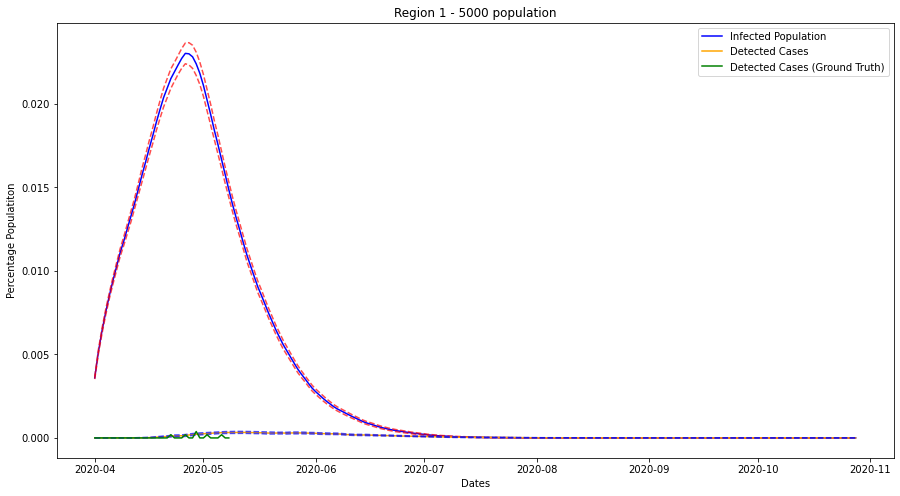

In [15]:
infected = temp['df_I']
detected = temp['df_DI']
inf_std = temp['df_Istd']
det_std = temp['df_DIstd']
plt.plot(infected, label='Infected Population', color='b')
plt.plot(infected - 1.96*inf_std/np.sqrt(sim), 'r--', alpha=0.7)
plt.plot(infected + 1.96*inf_std/np.sqrt(sim), 'r--', alpha=0.7)
plt.plot(detected, label='Detected Cases', color='orange')
plt.plot(detected - 1.96*det_std/np.sqrt(sim), 'b--', alpha=0.7)
plt.plot(detected + 1.96*det_std/np.sqrt(sim), 'b--', alpha=0.7)
plt.plot(list(infected.keys())[:date_length], S5_ts, color='g', label='Detected Cases (Ground Truth)')
plt.legend()
plt.title('Region 1 - 5000 population')
plt.ylabel('Percentage Populatiton')
plt.xlabel('Dates')

In [16]:
coeff = (S10['total_pop']*np.log(S10['total_pop'])*S5['area']*S5['F(S)']**2)/(S5['total_pop']*np.log(S5['total_pop'])*S10['area']*S10['F(S)']**2)

In [17]:
# With current testing and social distancing throughout
numNodes = S10['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, coeff)

final = []
initI = int(I*coeff)
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim)

t = 0.01
	 S   = 10318.0
	 E   = 64.0
	 I   = 15.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 1.0
	 F   = 0.0
t = 10.03
	 S   = 10239.0
	 E   = 53.0
	 I   = 70.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 33.0
	 F   = 3.0
[Checkpoint: Updating parameters]
t = 20.02
	 S   = 10104.0
	 E   = 66.0
	 I   = 131.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 87.0
	 F   = 10.0
[Checkpoint: Updating parameters]
t = 30.00
	 S   = 10032.0
	 E   = 33.0
	 I   = 127.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 188.0
	 F   = 16.0
t = 40.03
	 S   = 10030.0
	 E   = 3.0
	 I   = 85.0
	 D_E = 0.0
	 D_I = 6.0
	 R   = 254.0
	 F   = 20.0
[Checkpoint: Updating parameters]
t = 50.23
	 S   = 10028.0
	 E   = 0.0
	 I   = 32.0
	 D_E = 1.0
	 D_I = 3.0
	 R   = 309.0
	 F   = 25.0
t = 60.38
	 S   = 10027.0
	 E   = 0.0
	 I   = 16.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 325.0
	 F   = 28.0
t = 70.16
	 S   = 10027.0
	 E   = 0.0
	 I   = 7.0
	 D_E = 0.0
	 D_I = 2.0
	 R   = 334.0
	 F   = 28.0
t = 110.65
	 S   = 10027.0
	 E   = 0.0
	 I   = 0.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 3

Text(0.5, 0, 'Dates')

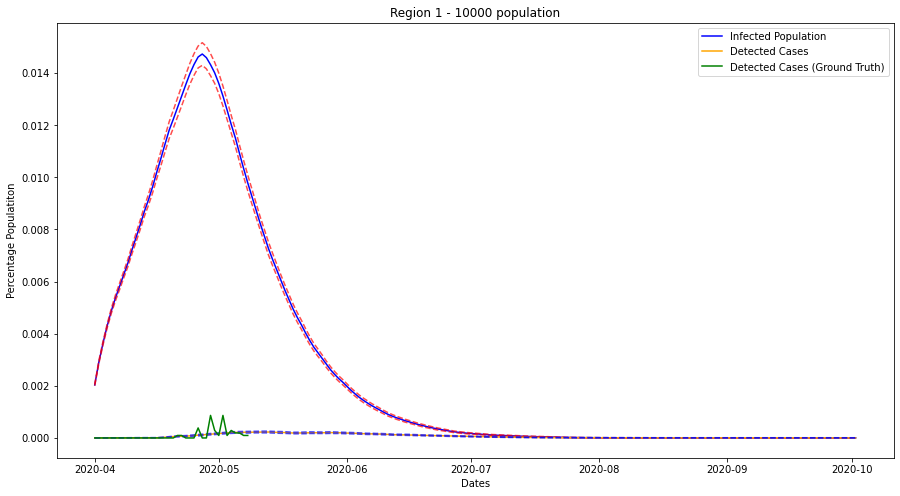

In [18]:
infected = temp['df_I']
detected = temp['df_DI']
inf_std = temp['df_Istd']
det_std = temp['df_DIstd']
plt.plot(infected, label='Infected Population', color='b')
plt.plot(infected - 1.96*inf_std/np.sqrt(sim), 'r--', alpha=0.7)
plt.plot(infected + 1.96*inf_std/np.sqrt(sim), 'r--', alpha=0.7)
plt.plot(detected, label='Detected Cases', color='orange')
plt.plot(detected - 1.96*det_std/np.sqrt(sim), 'b--', alpha=0.7)
plt.plot(detected + 1.96*det_std/np.sqrt(sim), 'b--', alpha=0.7)
plt.plot(list(infected.keys())[:date_length], S10_ts, color='g', label='Detected Cases (Ground Truth)')
plt.legend()
plt.title('Region 1 - 10000 population')
plt.ylabel('Percentage Populatiton')
plt.xlabel('Dates')

In [19]:
coeff = (S20['total_pop']*np.log(S20['total_pop'])*S5['area']*S5['F(S)']**2)/(S5['total_pop']*np.log(S5['total_pop'])*S20['area']*S20['F(S)']**2)

In [20]:
# With current testing and social distancing throughout
numNodes = S20['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, coeff)

final = []
initI = int(I*coeff)
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim)

t = 0.02
	 S   = 20894.0
	 E   = 107.0
	 I   = 28.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 0.0
	 F   = 0.0
t = 10.01
	 S   = 20743.0
	 E   = 90.0
	 I   = 133.0
	 D_E = 0.0
	 D_I = 0.0
	 R   = 60.0
	 F   = 3.0
[Checkpoint: Updating parameters]
t = 20.02
	 S   = 20469.0
	 E   = 148.0
	 I   = 226.0
	 D_E = 1.0
	 D_I = 1.0
	 R   = 173.0
	 F   = 11.0
[Checkpoint: Updating parameters]
t = 30.03
	 S   = 20236.0
	 E   = 82.0
	 I   = 331.0
	 D_E = 0.0
	 D_I = 5.0
	 R   = 353.0
	 F   = 22.0
t = 40.05
	 S   = 20231.0
	 E   = 20.0
	 I   = 210.0
	 D_E = 0.0
	 D_I = 5.0
	 R   = 536.0
	 F   = 27.0
[Checkpoint: Updating parameters]
t = 50.00
	 S   = 20223.0
	 E   = 5.0
	 I   = 107.0
	 D_E = 0.0
	 D_I = 4.0
	 R   = 655.0
	 F   = 35.0
t = 60.33
	 S   = 20223.0
	 E   = 1.0
	 I   = 52.0
	 D_E = 0.0
	 D_I = 5.0
	 R   = 711.0
	 F   = 37.0
t = 70.22
	 S   = 20223.0
	 E   = 0.0
	 I   = 26.0
	 D_E = 0.0
	 D_I = 5.0
	 R   = 737.0
	 F   = 38.0
t = 90.55
	 S   = 20223.0
	 E   = 0.0
	 I   = 4.0
	 D_E = 0.0
	 D_I = 2.0
	 

Text(0.5, 0, 'Dates')

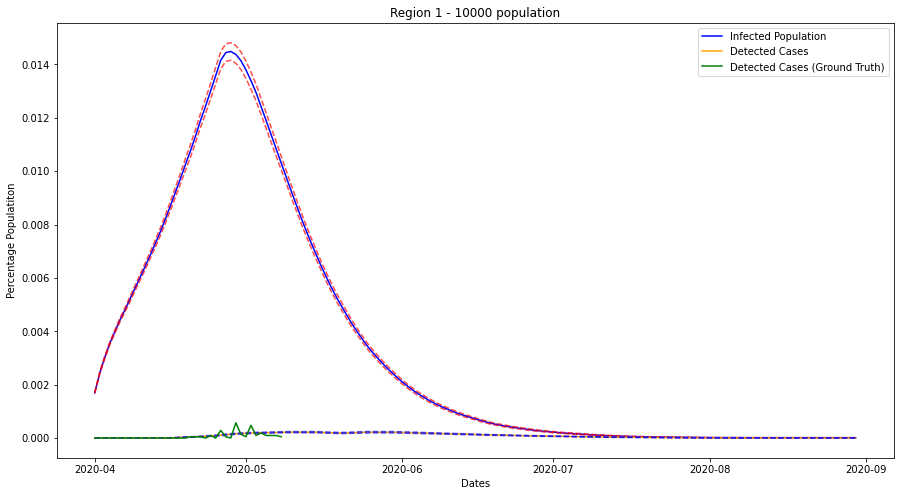

In [21]:
infected = temp['df_I']
detected = temp['df_DI']
inf_std = temp['df_Istd']
det_std = temp['df_DIstd']
plt.plot(infected, label='Infected Population', color='b')
plt.plot(infected - 1.96*inf_std/np.sqrt(sim), 'r--', alpha=0.7)
plt.plot(infected + 1.96*inf_std/np.sqrt(sim), 'r--', alpha=0.7)
plt.plot(detected, label='Detected Cases', color='orange')
plt.plot(detected - 1.96*det_std/np.sqrt(sim), 'b--', alpha=0.7)
plt.plot(detected + 1.96*det_std/np.sqrt(sim), 'b--', alpha=0.7)
plt.plot(list(infected.keys())[:date_length], S20_ts, color='g', label='Detected Cases (Ground Truth)')
plt.legend()
plt.title('Region 1 - 20000 population')
plt.ylabel('Percentage Populatiton')
plt.xlabel('Dates')